## ANN classifier

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim #Parameter optimization functions
import numpy as np
import random #Random shuffling
import matplotlib.pyplot as plt
from numpy import ma
from scipy.io import loadmat #Loading data
from sklearn.model_selection import train_test_split #Train/test data split.

In [2]:
#loadData function
def loadData(name):
    return(loadmat(name))

In [3]:
#Displays a image (one slice of input)
def showImage(img):
    img = img.reshape((20,20))
    img = np.transpose(img) #The dataset has the values transposed somehow?
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(img)
    

In [4]:
#Selects and shows a random image from X and prints it's corresponding label.
def showRandImage(X, y):
    index = np.random.randint(X.shape[0])
    img = X[index, :]
    print("The value is ", y[index])
    showImage(img)

In [5]:
#Unison shuffle. Reference from https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [6]:
#Load the data. 
data = loadData("ex3data1.mat")
X = data["X"]
y = data["y"][:,0]
X, y = unison_shuffled_copies(X,y)
y = y.reshape(y.shape[0], 1)
print("Input shape: ", X.shape)
print("Output shape: ", y.shape)

Input shape:  (5000, 400)
Output shape:  (5000, 1)


The value is  [2]


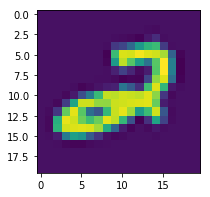

In [7]:
#Show one of our input data and label.
showRandImage(X, y)

As we see, the data we are given are images with the class label 1-10 corresponding to the value.

In [8]:
#Define the neural net.
class ANN(nn.Module):
    
    def __init__(self):
        #Define the network
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(400, 25)
        self.fc2 = nn.Linear(25,10)
        self.Sigmoid = nn.Sigmoid()
        self.Softmax = nn.Softmax(dim = -1)

    def forward(self, x):
        x = self.Sigmoid(self.fc1(x))
        x = self.Softmax(self.fc2(x))
        return(x)
    
    def loadWeight(self, weights):
        fc1 = torch.from_numpy(weights["Theta1"][:,:-1]).float()
        fc1Bias = torch.from_numpy(weights["Theta1"][:,0]).float()
        fc2 = torch.from_numpy(weights["Theta2"][:,:-1]).float()
        fc2Bias = torch.from_numpy(weights["Theta2"][:,0]).float()
        
        print(fc1.shape)
        print(fc1Bias)
        print(fc2Bias)
        
        param = list(self.parameters())
        param[0].data.sub_(fc1)
        param[1].data.sub_(fc1Bias)
        param[2].data.sub_(fc2)
        param[3].data.sub_(fc2Bias)


In [9]:
#Evaluate the network
def evaluate(model, X, y):
    dataSize = len(X[:,1]) #Total number of samples.
    #Test on the dataset
    #For each of the featureset.
    samples = list(range(dataSize))
    random.shuffle(samples)
    correct = 0

    with torch.no_grad():
        for i in samples:
            features = torch.from_numpy(X[i]).float()
            #Extract the correct value
            target = torch.zeros((10))
            target[y[i]-1] = 1.0
            #Predict
            outputs = model(features)
            _, predicted = torch.max(outputs, 0)
            correct += (int(predicted) == y[i]-1)

    return(100*correct/dataSize)

### Train the Network

In [10]:
#Initialize the neural net
classifier = ANN()
print(classifier)
#Create the optim
optimizer = optim.SGD(classifier.parameters(), lr=0.2)

ANN(
  (fc1): Linear(in_features=400, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
  (Sigmoid): Sigmoid()
  (Softmax): Softmax()
)


In [11]:
#Before training the accuracy is 10%. 
print("Accuracy%: ", evaluate(classifier, X, y))

Accuracy%:  [10.16]


In [12]:
def train(classifier, X,y, epochSize = 20 ):
    #Split into test and train.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    #Training.
    dataSize = len(X_train[:,1]) #Total number of samples.
    #Store the result here to plot graph.
    AccuracyCount = []
    LossCount = []
    for epoch in range(0,20):
        losses = []
        accuracyCount = []
        correctCount = 0
        #For each of the featureset.
        samples = list(range(dataSize))
        random.shuffle(samples)
        
        for i in samples:
            #Train with SGD for each set. |
            optimizer.zero_grad()   # zero the gradient
            #Extract a feature i
            features = torch.from_numpy(X_train[i]).float()
            #Extract the correct value
            target = torch.zeros((10))
            target[y_train[i]-1] = 1.0
            #Define the MSE loss.
            output = classifier(features)
            loss = nn.MSELoss()(output, target)
            #Backprop the loss to each node.
            loss.backward()
            #Updates our weights using optim SGD.
            optimizer.step()
            #Keep track of loss and accuracy.
            losses.append(loss)
        losses = np.array(losses, dtype=float)
        accuracy = evaluate(classifier, X_test, y_test)
        AccuracyCount.append(accuracy)
        mean = np.mean(losses)
        LossCount.append(mean)
        #Print every 2 epochs
        if epoch % 2 == 0:
            print("Epoch:"+ str(epoch) + " Avg MSE Loss:", mean, "Ave Accuracy%: ", accuracy)
    return(AccuracyCount, LossCount)

In [13]:
AccuracyCount, LossCount = train(classifier, X, y)

Epoch:0 Avg MSE Loss: 0.08710067111945578 Ave Accuracy%:  [41.6]
Epoch:2 Avg MSE Loss: 0.0423941570664756 Ave Accuracy%:  [80.93333333]
Epoch:4 Avg MSE Loss: 0.022137121501080402 Ave Accuracy%:  [88.6]
Epoch:6 Avg MSE Loss: 0.016128103424876698 Ave Accuracy%:  [90.53333333]
Epoch:8 Avg MSE Loss: 0.013598409172488378 Ave Accuracy%:  [90.8]
Epoch:10 Avg MSE Loss: 0.012095883613164354 Ave Accuracy%:  [91.]
Epoch:12 Avg MSE Loss: 0.010982411900111604 Ave Accuracy%:  [91.93333333]
Epoch:14 Avg MSE Loss: 0.00990078747340021 Ave Accuracy%:  [91.8]
Epoch:16 Avg MSE Loss: 0.0091430698697597 Ave Accuracy%:  [92.13333333]
Epoch:18 Avg MSE Loss: 0.00843664192675591 Ave Accuracy%:  [92.6]


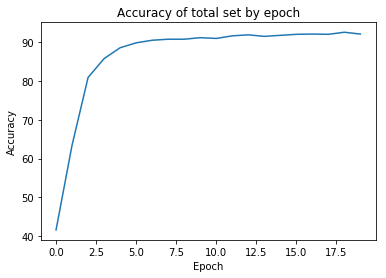

In [14]:
#Plot the accuracy gain
plt.plot(AccuracyCount)
plt.title('Accuracy of total set by epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

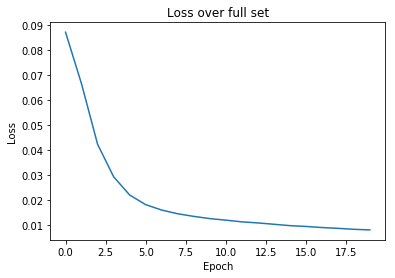

In [15]:
#Plot the loss rate
#Plot the accuracy gain
plt.plot(LossCount)
plt.title('Loss over full set')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Loading some pre-trained weights

We load some pre-trained weights and see if it help our training process.

In [16]:
#Clear and load our weights
weights = loadData("ex3weights.mat")
classifier.loadWeight(weights)

torch.Size([25, 400])
tensor([-0.0226, -0.0984,  0.1162, -0.2397, -0.7316, -0.5979,  0.1546, -0.0337,
        -0.4107,  0.0235,  0.2477,  0.2653,  0.0943,  0.2022, -0.2030,  0.1046,
         0.1489, -0.0379, -0.3320, -0.2977, -0.4842, -0.3898, -0.1832, -0.7021,
        -0.3509])
tensor([-0.7610, -0.6179, -0.6893, -0.6783, -0.5966, -0.8779, -0.5275, -0.7490,
        -0.6665, -0.4609])


In [17]:
print("Accuracy%: ", evaluate(classifier, X, y))

Accuracy%:  [34.72]


We can see immideatly the accuracy is at >10% of the whole dataset. There are features in the weights which helps our training as well. Nevertheless, are difference between the strategy of the loaded weights and my network's weights. (Perhaps the inputs to the loaded data are normalized). 

In [18]:
AccuracyCount, LossCount = train(classifier, X, y)

Epoch:0 Avg MSE Loss: 0.03717445277370271 Ave Accuracy%:  [82.2]
Epoch:2 Avg MSE Loss: 0.014524390370880306 Ave Accuracy%:  [88.6]
Epoch:4 Avg MSE Loss: 0.010982500348994156 Ave Accuracy%:  [89.93333333]
Epoch:6 Avg MSE Loss: 0.009131886030449746 Ave Accuracy%:  [90.8]
Epoch:8 Avg MSE Loss: 0.007952657536799655 Ave Accuracy%:  [91.6]
Epoch:10 Avg MSE Loss: 0.006991885649420141 Ave Accuracy%:  [91.86666667]
Epoch:12 Avg MSE Loss: 0.006423000998867418 Ave Accuracy%:  [92.26666667]
Epoch:14 Avg MSE Loss: 0.005900037219887905 Ave Accuracy%:  [92.26666667]
Epoch:16 Avg MSE Loss: 0.005518305303778015 Ave Accuracy%:  [92.4]
Epoch:18 Avg MSE Loss: 0.005138105070179425 Ave Accuracy%:  [92.33333333]


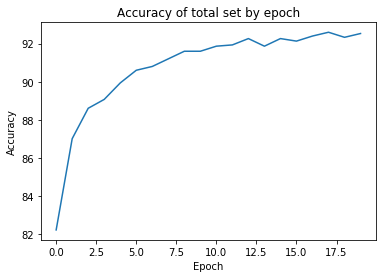

In [19]:
#Plot the accuracy gain
plt.plot(AccuracyCount)
plt.title('Accuracy of total set by epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

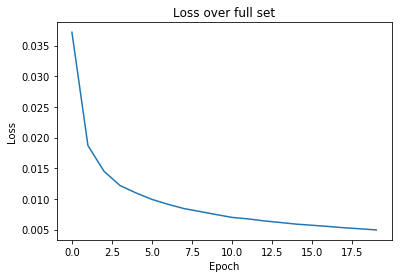

In [20]:
#Plot the loss rate
#Plot the accuracy gain
plt.plot(LossCount)
plt.title('Loss over full set')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

It appears that using the pretrained feature weights helped our model to train faster especially initially

### Predicting with regularized logistic regression strategy (One vs Many)

■ Compare the performance of the Neural Network and a Regularized
Logistic regression module (One-vs-all strategy) for multi-class

### Implementation of L2 regularized logistic regression, utilzing OvM strategy.

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
import math

In [24]:
#Normalize data
X_scaled = scale(X, axis=1) #We normalize our inputs using the difference to mean / std dev
#Test train split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [25]:
#Define helper functions
def sigmoid(x):
    #if X is <0 then we do subtraction form because python cant handle large positive exponents
    if x < 0:
        return 1 - 1/(1 + math.exp(x))
    else:
        return(1/(1+ math.exp(-x)))

vsigmoid = np.vectorize(sigmoid) #Use np.vectorise so we can apply function to our vectorized parameters

def logistic_cost(X_b, theta, y):
    #We define our cost function. Add some dust to prevent log from -inf when 0.
    ycost = (-y*ma.log(vsigmoid(X_b.dot(theta))).filled(0) - (1-y)*ma.log(1-vsigmoid(X_b.dot(theta))).filled(0))
    cost = ycost.mean() #We take the mean of the cost so we can record the value.
    return(cost)

def threshold(p): #The threshold of our probability converted to prediction.
    if(p>0.5):
        return(1)
    elif(p<0.5):
        return(0)
vthreshold = np.vectorize(threshold)

In [26]:
#Train our OVM model.
thetas = [] #Stores our model params for each class.
costs = [] #Stores the cost function for each class for debugging
for i in range(10): #We have 10 classes.

    y_train_ovm = np.zeros(y_train.shape)
    for index in range(len(y_train)):
        if y_train[index] == i: #Sets Y to 1 only if matches class i.
            y_train_ovm[index] = 1
        else:
            y_train_ovm[index] = 0

    #Logistic regression with regularization
    iterations = 1000
    learn_rate = 0.5
    reg_lambda = 0.5
    #Initialize theta to some values
    X_b = np.c_[np.ones((X_train.shape[0],1)), X_train]
    theta = np.zeros((X_b.shape[1],1))

    cost = []
    for iteration in range(iterations):
        delta = 1/X_train.shape[0] * X_b.T.dot(vsigmoid(X_b.dot(theta)) -y_train_ovm ) # Calculate delta 
        theta = theta - learn_rate*(delta + (reg_lambda/X_train.shape[0]) * theta) #We apply L2 regularization here. 
        cost.append(logistic_cost(X_b,theta,y_train_ovm))
    
    thetas.append(theta)
    costs.append(costs)

In [27]:
X_test = np.c_[np.ones(X_test.shape[0]),X_test] #Add the bias term to X_test

In [28]:
#Now we can predict for each instance using the highest class probability.
yHats = []
for i in range(10):
    yHat = vsigmoid(X_test.dot(thetas[i]))
    yHats.append(yHat)

In [29]:
#Predict for each instance using the highest class probability.
yFinal = []
for i in range(len(yHat)):
    highest = 0 #The highest index.
    probability = 0 #The highest probability.
    for j in range(10): #We have 10 classes.
        if yHats[j][i] > probability:
            probability = yHats[j][i]
            highest = j
    yFinal.append(highest)

In [30]:
correct = 0
for i in range(len(yFinal)):
    if yFinal[i] == y_test[i]:
        correct += 1

In [33]:
print("Our accuracy: %", 100*correct/len(yFinal))

Our accuracy: % 80.8
